# Workflow to load cell ranger outs and prepare data for clustering and analysis

## Data loading, QC filtering and Normalization
### Removing doublets + ambient mRNA

In [1]:
import scanpy as sc
import scipy
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import gc
import psutil
from typing import Optional, Tuple, Dict, Any
import logging

# Configure scanpy for large datasets
sc.settings.verbosity = 2
sc.settings.set_figure_params(dpi=80, facecolor='white')
sc.settings.n_jobs = -1  # Use all available cores

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [4]:
# Memory management utilities
def check_memory_usage():
    """Check current memory usage"""
    process = psutil.Process()
    memory_info = process.memory_info()
    memory_gb = memory_info.rss / (1024 ** 3)
    logger.info(f"Current memory usage: {memory_gb:.2f} GB")
    return memory_gb

def optimize_memory(adata):
    """Optimize memory usage for large datasets"""
    # Convert to sparse if dense
    if not hasattr(adata.X, 'toarray'):
        adata.X = scipy.sparse.csr_matrix(adata.X)
    
    # Optimize dtypes
    for col in adata.obs.columns:
        if adata.obs[col].dtype == 'object':
            adata.obs[col] = adata.obs[col].astype('category')
    
    # Force garbage collection
    gc.collect()
    return adata

#### Loading outs into adata for the first time

In [10]:
aggr_csv_path = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/cellranger_aggr/aggregation.csv' 
aggr_df = pd.read_csv(aggr_csv_path)
suffix_to_sample_map = {
    str(i + 1): sample_name
    for i, sample_name in enumerate(aggr_df['sample_id'])
}
logger.info("Created mapping from barcode suffix to sample ID:")
print(suffix_to_sample_map)

matrix_dir = "/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/cellranger_aggr/count/filtered_gene_bc_matrix"
# Load the full matrix
adata = sc.read_10x_mtx(
    matrix_dir,
    var_names='gene_symbols',
    cache=True,
    gex_only=True
)

# Extract the numeric suffix from each barcode (e.g., '1', '2', '8')
barcode_suffixes = adata.obs.index.str.split('-').str[-1]
# Use the .map() function to apply our dictionary to the suffixes
adata.obs['sample_id'] = barcode_suffixes.map(suffix_to_sample_map)
# get the condition before the underscore in the sample_id
adata.obs['condition'] = adata.obs['sample_id'].str.split('_').str[0]
# get the sex as the first letter after underscore in the sample_id (remove the number)
adata.obs['sex'] = adata.obs['sample_id'].str.split('_').str[1].str[0]

INFO:__main__:Created mapping from barcode suffix to sample ID:


{'1': 'KO_F785', '2': 'KO_F706', '3': 'WT_F3', '4': 'WT_F4', '5': 'KO_M764', '6': 'WT_M2', '7': 'KO_M784', '8': 'WT_M6'}


In [26]:
adata = sc.read_h5ad('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/cellranger_aggr/ERCC1_KO_mice_aggr.h5ad')
adata.obs['sample_id'] = adata.obs['sample_id'].str.split('_').str[1] + '_' + adata.obs['sample_id'].str.split('_').str[0]

### Sample specific QC cells and genes (as there are two separate batches)

In [27]:
# Calculate QC metrics
adata.var['mt'] = adata.var_names.str.startswith('mt-')
adata.var['ribo'] = adata.var_names.str.startswith(('rps', 'rpl'))
adata.var["hb"] = adata.var_names.str.contains("^hb[^(p)]")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 65106 × 32285
    obs: 'sample_id', 'condition', 'sex', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [28]:
adata.obs['total_counts_mt']

AAACCCGCAATCGTGG-1     29.0
AAACCCGCAATTAGGC-1     30.0
AAACCCGCACTAGGCA-1    106.0
AAACCCGCAGCCATCT-1     45.0
AAACGGACAAATCGTA-1     69.0
                      ...  
TGTGCCCTCCACCTGC-8     61.0
TGTGCCCTCCTCTCTC-8     38.0
TGTGCCCTCGTCTCGC-8     20.0
TGTGCCCTCTAACCTC-8      7.0
TGTGCCCTCTAAGTCG-8     16.0
Name: total_counts_mt, Length: 65106, dtype: float32

In [29]:
# find the total counts of the cells per sample
display(adata.obs['total_counts'].groupby(adata.obs['sample_id']).sum())
# find the total counts of the cells per condition
display(adata.obs['total_counts'].groupby(adata.obs['condition']).sum())
# find the total counts of the cells per sex
display(adata.obs['total_counts'].groupby(adata.obs['sex']).sum())

sample_id
F3_WT      23813824.0
F4_WT      23210428.0
F706_KO    26614592.0
F785_KO    15184107.0
M2_WT       9299179.0
M6_WT      15423842.0
M764_KO    14190527.0
M784_KO    19447942.0
Name: total_counts, dtype: float32

condition
KO    75437168.0
WT    71747272.0
Name: total_counts, dtype: float32

sex
F    88822952.0
M    58361488.0
Name: total_counts, dtype: float32

/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/s

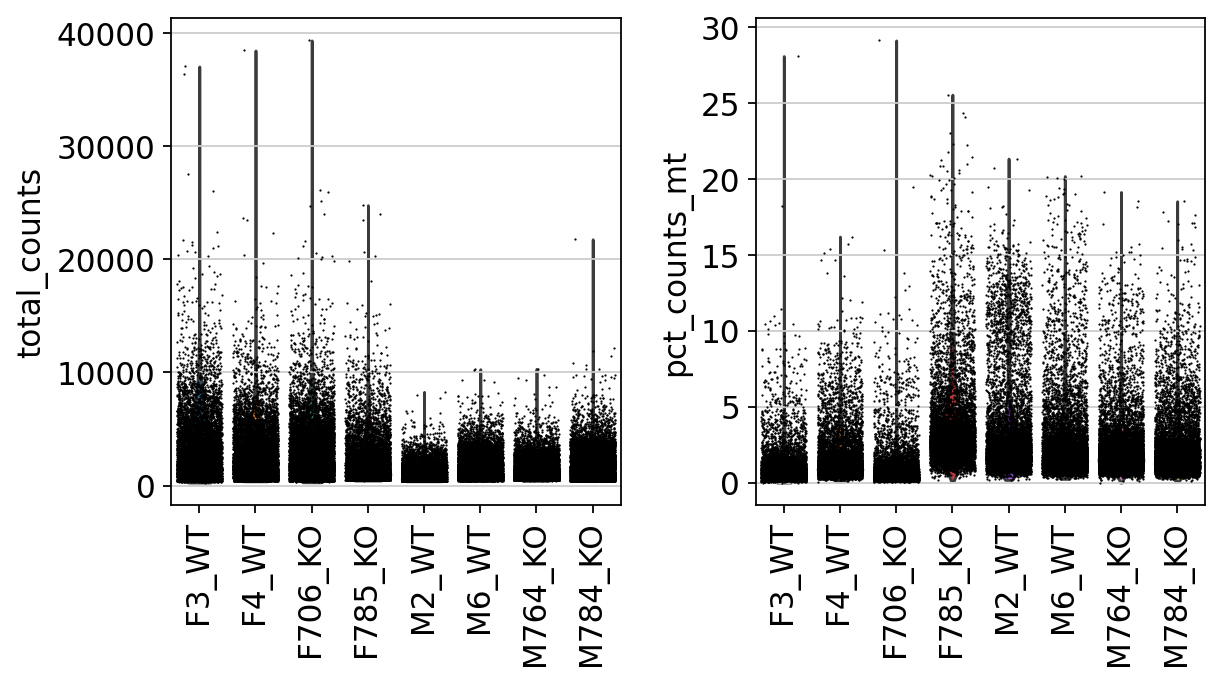

In [31]:
sc.pl.violin(
    adata,
    ["total_counts", "pct_counts_mt"],
    groupby='sample_id',
    jitter=0.4,
    multi_panel=True,
    rotation=90
)

In [32]:
def is_outlier(adata, metric: str, nmads: int):
    from scipy.stats import median_abs_deviation
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [58]:
# Initialize the outlier column to False
adata.obs["outlier"] = False

for sample in adata.obs["sample_id"].unique():
    idx = adata.obs["sample_id"] == sample
    # Subset adata for this sample
    adata_sample = adata[idx]
    # Calculate outliers for this sample only
    outlier_mask = (
        is_outlier(adata_sample, "log1p_total_counts", 5)
        | is_outlier(adata_sample, "log1p_n_genes_by_counts", 5)
        | is_outlier(adata_sample, "pct_counts_in_top_20_genes", 5)
    )
    # Assign back to the main adata.obs
    adata.obs.loc[idx, "outlier"] = outlier_mask.values

In [59]:
adata.obs.groupby("sample_id").outlier.value_counts()

sample_id  outlier
F3_WT      False      6519
           True        113
F4_WT      False      7587
           True         68
F706_KO    False      7511
           True        115
F785_KO    False      6324
           True         39
M2_WT      False      8368
           True         24
M6_WT      False      8796
           True         95
M764_KO    False      9390
           True         73
M784_KO    False      9962
           True        122
Name: count, dtype: int64

## Data integration

## Clustering and annotation